In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller
import pandas as pd

warnings.filterwarnings("ignore")



In [20]:
sbi=pd.read_csv("NII SBI.csv")
hdfc=pd.read_csv("nii hdfc.csv")

In [29]:
sbi.head()

,QUARTERS,NII,GROSS ADVANCE,GNPA,GNPAR,CASA,PCR,WDR,WLR
0,2016-17 Q1,18246.0,1859513.0,137662.0,7.40,42.78,61.57,7.61,11.14
1,2016-17 Q2,18119.0,1874715.0,159806.0,8.52,40.90,58.57,7.48,11.10
2,2016-17 Q3,17769.0,1877278.0,108172.0,5.76,46.55,58.96,7.33,11.06
3,2016-17 Q4,21065.0,1952507.0,177866.0,9.11,44.40,45.48,7.11,10.88
4,2017-18 Q1,17606.0,1886666.0,188068.0,9.97,44.38,60.79,6.90,10.62


In [30]:
hdfc.head()

,QUARTERS,NII,GROSS ADVANCE,GNPA,GNPAR,CASA,PCR,WDR,WLR
0,2016-17 Q1,7781.4,470622.0,4894.47,1.04,40.0,69.6,7.69,11.54
1,2016-17 Q2,7993.6,494418.0,5043.06,1.02,40.0,70.6,7.54,11.47
2,2016-17 Q3,8309.1,495043.0,6386.05,1.29,44.0,70.0,7.38,11.30
3,2016-17 Q4,9055.1,555000.0,5827.50,1.05,48.0,68.6,7.05,11.09
4,2017-18 Q1,9370.7,580975.8,7204.10,1.24,44.0,65.0,6.88,10.76


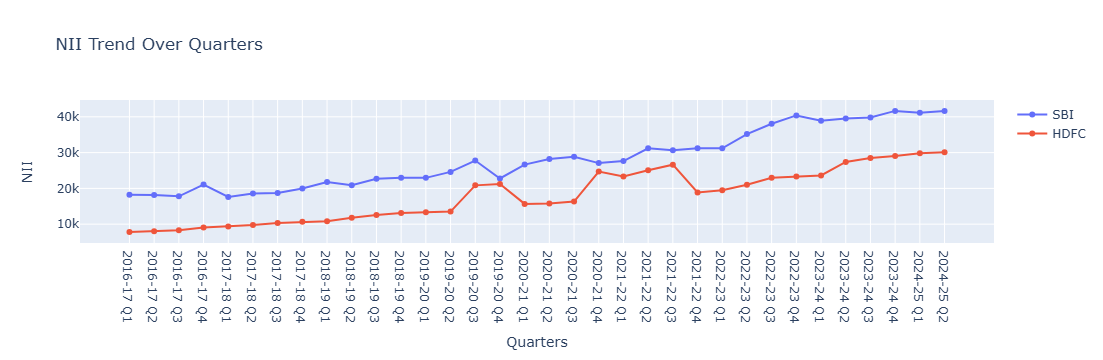

In [31]:
import plotly.graph_objects as go

fig = go.Figure()

# Add first dataset
fig.add_trace(go.Scatter(x=sbi["QUARTERS"], y=sbi["NII"], mode="lines+markers", name="SBI"))

# Add second dataset
fig.add_trace(go.Scatter(x=hdfc["QUARTERS"], y=hdfc["NII"], mode="lines+markers", name="HDFC"))

# Update layout
fig.update_layout(title="NII Trend Over Quarters", xaxis_title="Quarters", yaxis_title="NII")

fig.show()


# `Insights`


## Jump in 2019 Q3

- In 2019, the RBI cut the repo rate multiple times to boost economic growth.

- By October 2019 (Q3), the repo rate was at 5.15%, leading to lower borrowing costs and an increase in loan demand.

- Banks like SBI and HDFC likely expanded their lending, resulting in higher interest income.

- Q3 typically sees an increase in personal loans, home loans, and vehicle loans due to festive demand (Diwali, Navratri).


## Dip in SBI , no Dip in HDFC in 2019 Q4

- **SBI’s Q4 dip** was likely due to **higher NPA provisions, corporate loan stress, interest reversals, and early COVID impact.**  
-  **HDFC remained stable** due to its **retail loan dominance and lower exposure to stressed sectors.**  

## More

- SBI's NII showed steady growth with a peak in 2021-22 Q2, likely due to strong credit demand and post-COVID recovery.

- HDFC saw a sharp rise in NII in 2020-21 Q4 but dropped significantly in 2021-22 Q3, possibly due to interest rate changes and lower loan disbursements.

- SBI remained stable after 2021-22 Q2, while HDFC faced fluctuations, indicating different risk management and loan portfolio strategies.

- SBI maintained consistent growth, whereas HDFC experienced volatility, reflecting different impacts of economic conditions and policy changes.




In [22]:
def adftest(df):
  is_stationary = True
  for col in df.columns.values[1:]:
    test_result = adfuller(df[col], autolag="AIC")
    if test_result[1] > 0.05:
      is_stationary = False
    print(col, test_result[1] < 0.05)

  return is_stationary


In [41]:
# sbi['NII'].diff()[1:]

In [45]:
# adfuller(sbi['NII'].diff().dropna(), autolag="AIC")[1]>0.05

False

In [27]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

def find_diff_order(df, max_diff=5):
    diff_orders = {}
    
    for col in df.columns.values[1:]:
        temp_series = df[col]
        diff_count = 0
        
        while diff_count < max_diff:
            test_result = adfuller(temp_series.dropna(), autolag="AIC")
            if test_result[1] < 0.05:
                break
            temp_series = temp_series.diff()
            diff_count += 1
        
        diff_orders[col] = diff_count
    
    return diff_orders

# Example usage



In [28]:
diff_needed = find_diff_order(sbi)
print(diff_needed)

{'NII': 1, 'GROSS ADVANCE': 2, 'GNPA': 1, 'GNPAR': 1, 'CASA': 1, 'PCR': 2, 'WDR': 3, 'WLR': 4}


In [29]:
diff_needed = find_diff_order(hdfc)
print(diff_needed)

{'NII': 1, 'GROSS ADVANCE': 4, 'GNPA': 1, 'GNPAR': 0, 'CASA': 0, 'PCR': 1, 'WDR': 3, 'WLR': 0}


number of times differencing 1


[]

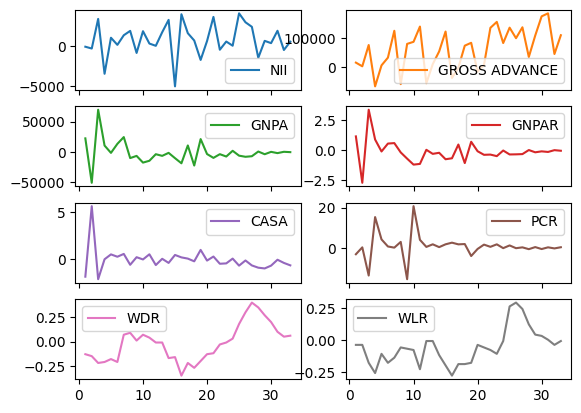

In [25]:
is_stationary = False
sbi_diff = sbi.drop("QUARTERS",axis=1).copy()
count_diff = 0

while not is_stationary:
  sbi_diff = sbi_diff.diff().dropna()
  is_stationary = adftest(pd.DataFrame(sbi_diff['NII']))
  count_diff += 1
  
  
print("number of times differencing", count_diff)
sbi_diff.plot(subplots=True, layout=(4, 2))
plt.plot()

# Modelling begins

In [105]:
# Train-Test Split (80-20 Split Example)
split_ratio = 0.8
split_index = int(len(sbi['NII']) * split_ratio)

train =sbi['NII'][:split_index]  # First 80% for training
test =sbi['NII'][split_index:]   # Remaining 20% for testing

print(f"Train Size: {len(train)}, Test Size: {len(test)}")


Train Size: 27, Test Size: 7


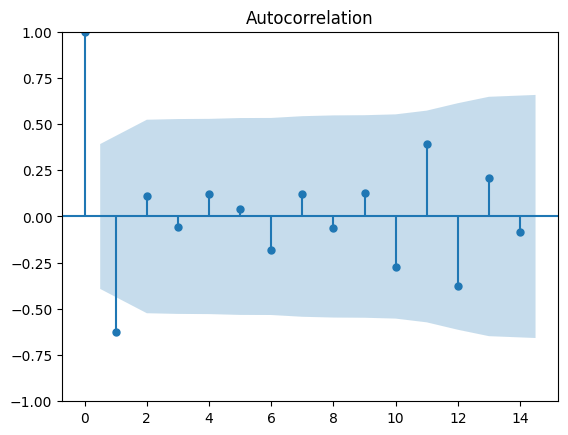

In [113]:
from statsmodels.graphics.tsaplots import *
import matplotlib.pyplot as plt

plot_acf(train.diff().diff().dropna())
plt.show()


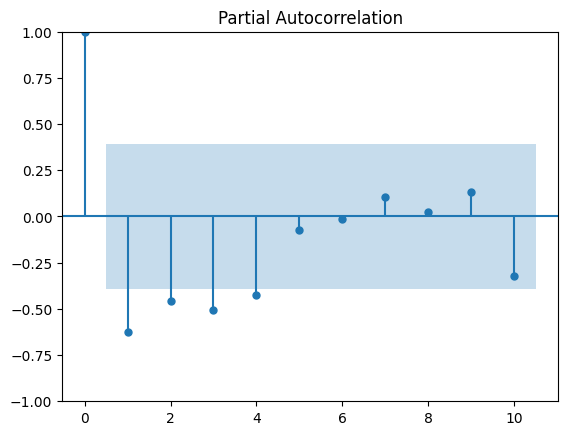

In [114]:
from statsmodels.graphics.tsaplots import plot_acf

plot_pacf(train.diff().diff().dropna(),lags=10)
plt.show()


In [34]:
import pandas as pd
import numpy as np
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

warnings.filterwarnings("ignore")

# Define AR and MA parameters
ar_values = [1,2,3,4]
ma_value = 1

# DataFrame to store results
results = []

# Loop through AR values
for ar in ar_values:
    model = ARIMA(train, order=(ar, 1, ma_value))
    result = model.fit()
    
    # Forecast
    forecast = result.get_forecast(steps=len(test))
    forecast_values = forecast.predicted_mean
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(test, forecast_values)
    
    # Store results
    results.append([f'ARIMA({ar},1,{ma_value})', result.aic, result.bic, mape])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'AIC', 'BIC', 'MAPE'])

# Display the best model
best_model = results_df.loc[results_df[['AIC', 'BIC']].sum(axis=1).idxmin()]
print("Best Model:\n", best_model)

# Display all results
print(results_df)


Best Model:
 Model    ARIMA(1,1,1)
AIC        480.133317
BIC        483.907606
MAPE         0.064962
Name: 0, dtype: object
          Model         AIC         BIC      MAPE
0  ARIMA(1,1,1)  480.133317  483.907606  0.064962
1  ARIMA(2,1,1)  480.339227  485.371613  0.072574
2  ARIMA(3,1,1)  481.474051  487.764533  0.054448
3  ARIMA(4,1,1)  480.442542  487.991122  0.023415


In [ ]:
fitted_values = pd.Series(result.fittedvalues, index=train.index[1:])  
fitted_values

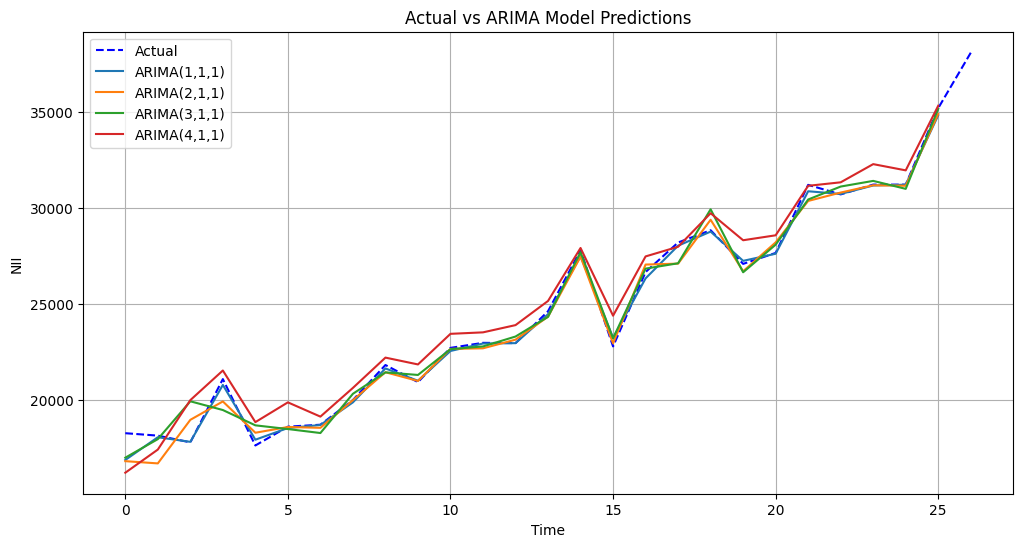

In [141]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot actual series
plt.plot(train.index, train, label="Actual", color="blue", linestyle="--")

# Loop through AR values and plot predictions
for ar in ar_values:
    model = ARIMA(train, order=(ar, 1, ma_value))
    result = model.fit()

    # Get fitted values and align them properly
    fitted_values = pd.Series(result.fittedvalues, index=train.index[1:])  

    # Plot fitted values
    plt.plot(range(0,26), fitted_values, label=f"ARIMA({ar},1,{ma_value})", )

plt.title("Actual vs ARIMA Model Predictions")
plt.xlabel("Time")
plt.ylabel("NII")
plt.legend()
plt.grid()
plt.show()


# Residual Analysis

In [118]:
result

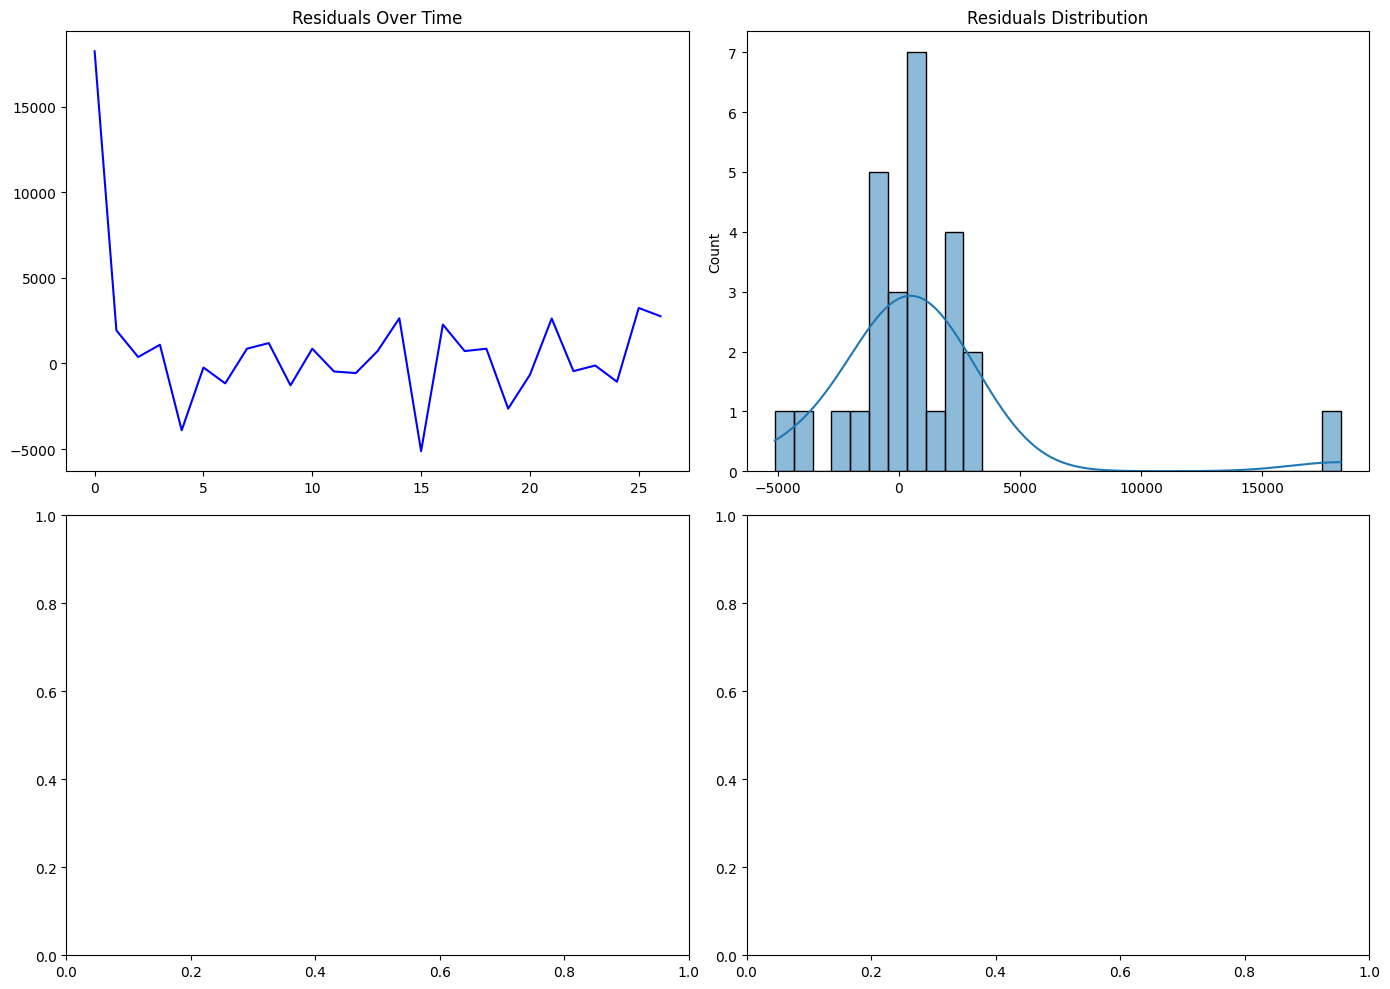

Shapiro-Wilk Test: W=0.6654181480407715, p-value=1.326756091657444e-06
     lb_stat  lb_pvalue
10  1.119323   0.999712


In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA Model
# arima_model = ARIMA(train, order=(p, d, q))  # Replace p, d, q with best values
# arima_result = arima_model.fit()

# Get Residuals
residuals = result.resid

# Create Subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residuals Over Time
axes[0, 0].plot(residuals, color='blue')
axes[0, 0].set_title('Residuals Over Time')

# Histogram of Residuals (Check Normality)
sns.histplot(residuals, bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Residuals Distribution')


plt.tight_layout()
plt.show()

# Perform Normality Test (Shapiro-Wilk)
from scipy.stats import shapiro
shapiro_test = shapiro(residuals)
print(f'Shapiro-Wilk Test: W={shapiro_test.statistic}, p-value={shapiro_test.pvalue}')

# Perform Ljung-Box Test (Check for White Noise)
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_test)


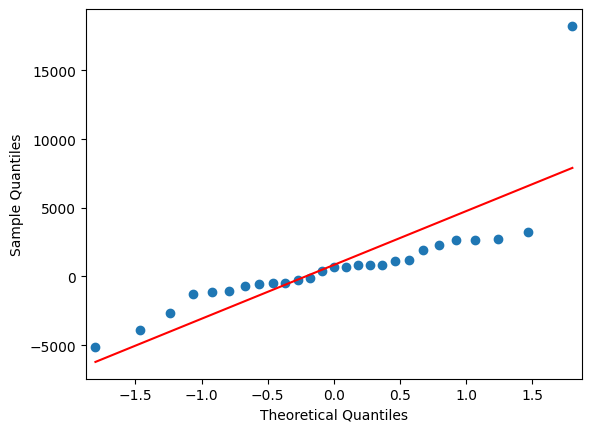

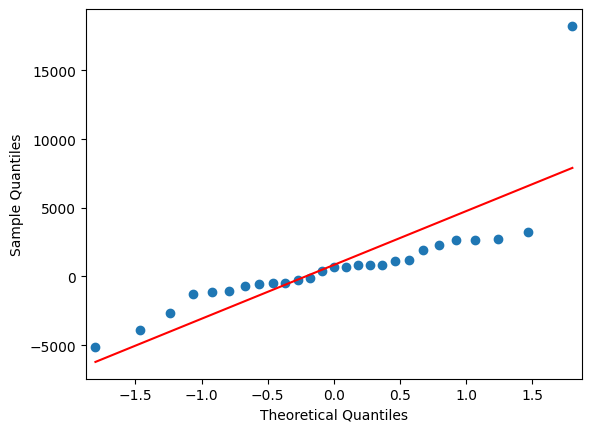

In [120]:
# 5. Q-Q Plot (Check for Normality)
sm.qqplot(residuals, line='s')
# axes[2, 0].set_title('Q-Q Plot of Residuals')

###  HDFC

In [41]:
is_stationary = False
hdfc_diff = hdfc.drop("QUARTERS",axis=1).copy()
count_diff = 0

while not is_stationary:
  hdfc_diff = hdfc_diff.diff().dropna()
  is_stationary = adftest(pd.DataFrame(hdfc_diff['NII']))
  count_diff += 1
  
  
print("number of times differencing", count_diff)
hdfc_diff.plot(subplots=True, layout=(4, 2))
plt.plot()

NameError: name 'adftest' is not defined

Train Size: 27, Test Size: 7


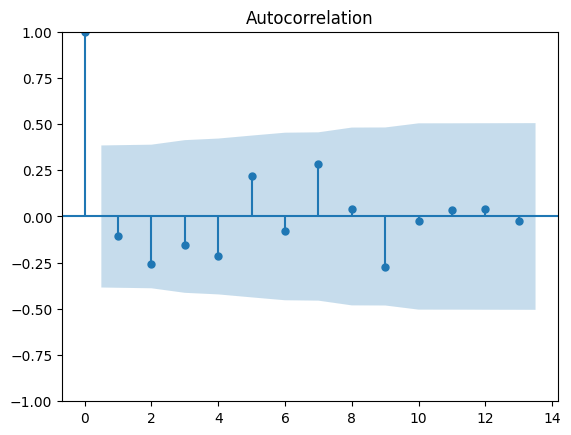

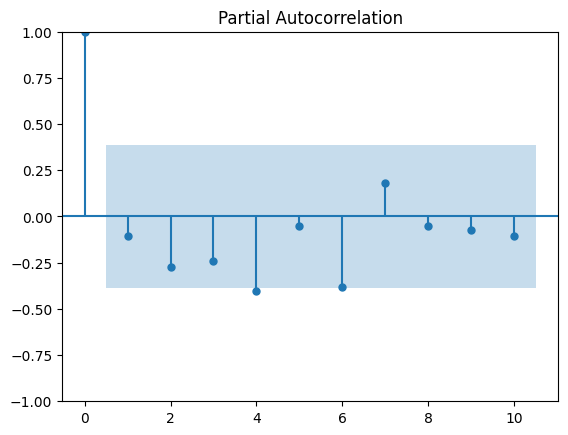

Best Model:
 Model    ARIMA(1,1,3)
AIC        495.942564
BIC        502.233046
MAPE         0.171735
Name: 0, dtype: object
          Model         AIC         BIC      MAPE
0  ARIMA(1,1,3)  495.942564  502.233046  0.171735
1  ARIMA(4,1,3)  501.026941  511.091713  0.195851
2  ARIMA(6,1,3)  501.653312  514.234277  0.093337


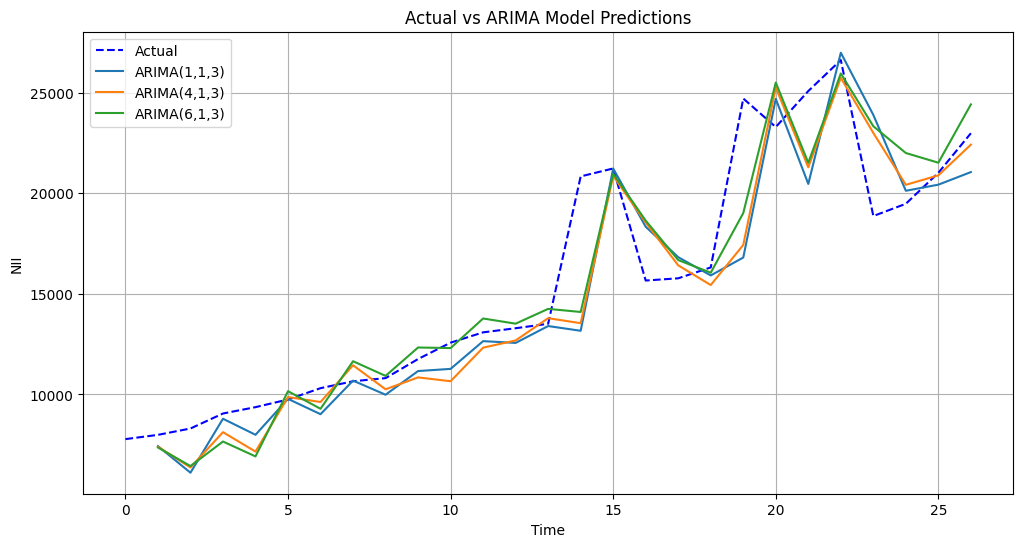

In [10]:
# Train-Test Split (80-20 Split Example)
split_ratio = 0.8
split_index = int(len(hdfc['NII']) * split_ratio)

train =hdfc['NII'][:split_index]  # First 80% for training
test =hdfc['NII'][split_index:]   # Remaining 20% for testing

print(f"Train Size: {len(train)}, Test Size: {len(test)}")
from statsmodels.graphics.tsaplots import *
import matplotlib.pyplot as plt

plot_acf(train.diff().dropna())
plt.show()
from statsmodels.graphics.tsaplots import plot_acf

plot_pacf(train.diff().dropna(),lags=10)
plt.show()
import pandas as pd
import numpy as np
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

warnings.filterwarnings("ignore")

# Define AR and MA parameters
ar_values = [1, 4,6]
ma_value = 3

# DataFrame to store results
results = []

# Loop through AR values
for ar in ar_values:
    model = ARIMA(train, order=(ar, 1, ma_value))
    result = model.fit()
    
    # Forecast
    forecast = result.get_forecast(steps=len(test))
    forecast_values = forecast.predicted_mean
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(test, forecast_values)
    
    # Store results
    results.append([f'ARIMA({ar},1,{ma_value})', result.aic, result.bic, mape])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'AIC', 'BIC', 'MAPE'])

# Display the best model
best_model = results_df.loc[results_df[['AIC', 'BIC']].sum(axis=1).idxmin()]
print("Best Model:\n", best_model)

# Display all results
print(results_df)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot actual series
plt.plot(train.index, train, label="Actual", color="blue", linestyle="--")

# Loop through AR values and plot predictions
for ar in ar_values:
    model = ARIMA(train, order=(ar, 1, ma_value))
    result = model.fit()

    # Get fitted values and align them properly
    fitted_values = pd.Series(result.fittedvalues, index=train.index[1:])  

    # Plot fitted values
    plt.plot(fitted_values.index, fitted_values, label=f"ARIMA({ar},1,{ma_value})", )

plt.title("Actual vs ARIMA Model Predictions")
plt.xlabel("Time")
plt.ylabel("NII")
plt.legend()
plt.grid()
plt.show()


# AR model

## SBI

Train Size: 27, Test Size: 7

Results:
    Model         AIC         BIC      MAPE
0  AR(1)  456.068047  459.724674  0.021158
1  AR(2)  437.100193  441.812409  0.030479
2  AR(3)  418.562889  424.240360  0.060262
3  AR(4)  399.602467  406.148721  0.062297

Best Model:
 Model         AR(4)
AIC      399.602467
BIC      406.148721
MAPE       0.062297
Name: 3, dtype: object


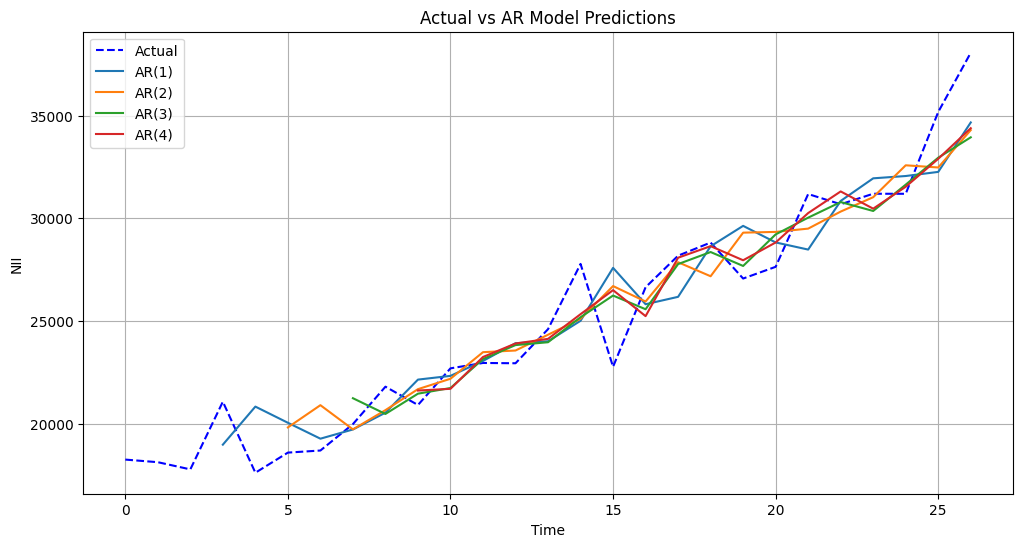

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_percentage_error


# 1️⃣ Train-Test Split
split_ratio = 0.8
split_index = int(len(sbi['NII']) * split_ratio)

train = sbi['NII'][:split_index]  # First 80% for training
test = sbi['NII'][split_index:]   # Remaining 20% for testing

print(f"Train Size: {len(train)}, Test Size: {len(test)}")

# 2️⃣ AR Lag Values
ar_values = [1, 2,3,4]

# 3️⃣ Store Results
results = []

# 4️⃣ Loop through AR lags for evaluation
for ar in ar_values:
    # Fit AR model on differenced data
    model = AutoReg(train.diff().dropna(), lags=ar)
    result = model.fit()
    
    # Forecast for the length of the test set
    forecast_diff = result.predict(start=len(train.diff().dropna()), 
                                   end=len(train.diff().dropna()) + len(test) - 1)
    
    # Convert differenced forecast back to original scale
    last_train_value = train.iloc[-1]
    forecast = last_train_value + forecast_diff.cumsum()

    # Calculate MAPE on the original scale
    mape = mean_absolute_percentage_error(test, forecast)
    
    # Store results
    results.append([f'AR({ar})', result.aic, result.bic, mape])

# 5️⃣ Convert to DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'AIC', 'BIC', 'MAPE'])

# 6️⃣ Display Best Model Based on AIC+BIC
best_model = results_df.loc[results_df[['AIC', 'BIC']].sum(axis=1).idxmin()]
print("\nResults:\n", results_df)
print("\nBest Model:\n", best_model)

# 🟡 Plotting Actual vs Fitted Values
plt.figure(figsize=(12, 6))

# Plot actual series
plt.plot(train.index, train, label="Actual", color="blue", linestyle="--")

# Loop through AR values and plot predictions
for ar in ar_values:
    # Correct differencing
    diff_train = train.diff().dropna()

    # Fit AR model with given lag
    model = AutoReg(diff_train, lags=ar)
    result = model.fit()

    # Get fitted values and realign to original scale
    fitted_diff = result.fittedvalues
    fitted_values = train.shift(1).dropna()[ar:] + fitted_diff[ar:]

    # Plot fitted values
    plt.plot(fitted_values.index, fitted_values, label=f"AR({ar})")

plt.title("Actual vs AR Model Predictions")
plt.xlabel("Time")
plt.ylabel("NII")
plt.legend()
plt.grid()
plt.show()


Train Size: 27, Test Size: 7

Results:
    Model         AIC         BIC      MAPE
0  AR(1)  476.909921  480.566549  0.080929
1  AR(3)  441.919518  447.596989  0.107947
2  AR(5)  404.724167  412.035824  0.110088
3  AR(7)  366.735513  375.235464  0.154399

Best Model:
 Model         AR(7)
AIC      366.735513
BIC      375.235464
MAPE       0.154399
Name: 3, dtype: object


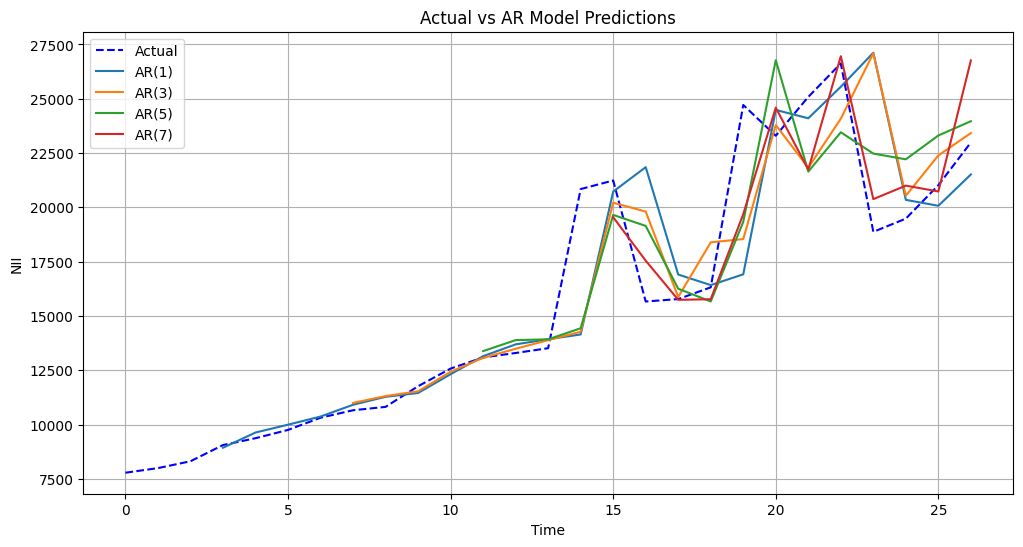

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_percentage_error


# 1️⃣ Train-Test Split
split_ratio = 0.8
split_index = int(len(hdfc['NII']) * split_ratio)

train = hdfc['NII'][:split_index]  # First 80% for training
test = hdfc['NII'][split_index:]   # Remaining 20% for testing

print(f"Train Size: {len(train)}, Test Size: {len(test)}")

# 2️⃣ AR Lag Values
ar_values = [1, 3, 5, 7]

# 3️⃣ Store Results
results = []

# 4️⃣ Loop through AR lags for evaluation
for ar in ar_values:
    # Fit AR model on differenced data
    model = AutoReg(train.diff().dropna(), lags=ar)
    result = model.fit()
    
    # Forecast for the length of the test set
    forecast_diff = result.predict(start=len(train.diff().dropna()), 
                                   end=len(train.diff().dropna()) + len(test) - 1)
    
    # Convert differenced forecast back to original scale
    last_train_value = train.iloc[-1]
    forecast = last_train_value + forecast_diff.cumsum()

    # Calculate MAPE on the original scale
    mape = mean_absolute_percentage_error(test, forecast)
    
    # Store results
    results.append([f'AR({ar})', result.aic, result.bic, mape])

# 5️⃣ Convert to DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'AIC', 'BIC', 'MAPE'])

# 6️⃣ Display Best Model Based on AIC+BIC
best_model = results_df.loc[results_df[['AIC', 'BIC']].sum(axis=1).idxmin()]
print("\nResults:\n", results_df)
print("\nBest Model:\n", best_model)

# 🟡 Plotting Actual vs Fitted Values
plt.figure(figsize=(12, 6))

# Plot actual series
plt.plot(train[].index, train, label="Actual", color="blue", linestyle="--")

# Loop through AR values and plot predictions
for ar in ar_values:
    # Correct differencing
    diff_train = train.diff().dropna()

    # Fit AR model with given lag
    model = AutoReg(diff_train, lags=ar)
    result = model.fit()

    # Get fitted values and realign to original scale
    fitted_diff = result.fittedvalues
    fitted_values = train.shift(1).dropna()[ar:] + fitted_diff[ar:]

    # Plot fitted values
    plt.plot(fitted_values.index, fitted_values, label=f"AR({ar})")

plt.title("Actual vs AR Model Predictions")
plt.xlabel("Time")
plt.ylabel("NII")
plt.legend()
plt.grid()
plt.show()


### EXPONENTIAL

#### SBI

SBI - AIC: 409.08, BIC: 419.45, MAPE: 0.0487
HDFC - AIC: 445.96, BIC: 456.33, MAPE: 0.0430


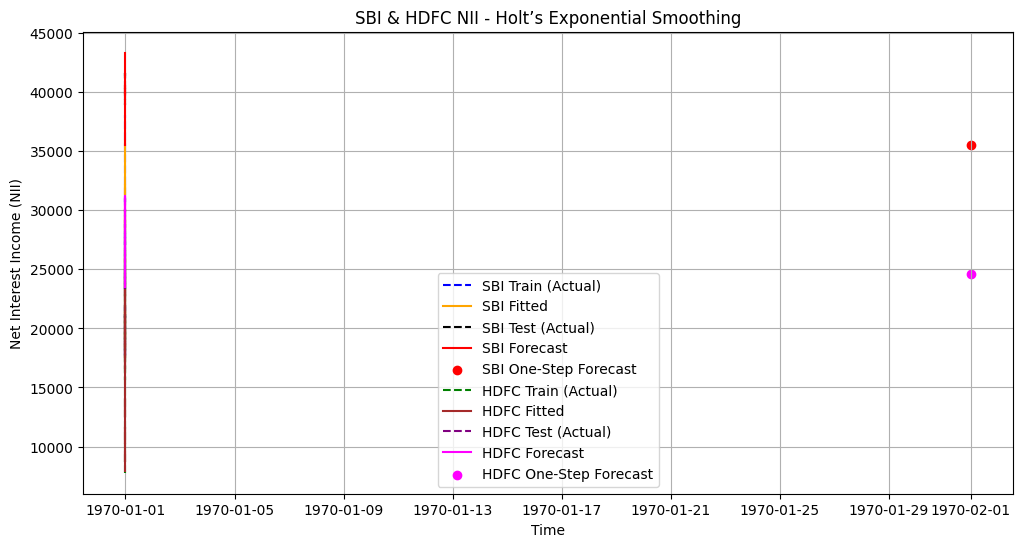

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error

# Ensure the Date column is in datetime format
sbi.index = pd.to_datetime(sbi.index)
hdfc.index = pd.to_datetime(hdfc.index)
# sbi = sbi.drop("QUARTERS", axis=1).copy()
# hdfc = hdfc.drop("QUARTERS", axis=1).copy()

# Split into train and test (80% training, 20% testing)
train_size_sbi = int(len(sbi) * 0.8)
train_size_hdfc = int(len(hdfc) * 0.8)

train_sbi, test_sbi = sbi["NII"][ :train_size_sbi], sbi["NII"][train_size_sbi:]
train_hdfc, test_hdfc = hdfc["NII"][ :train_size_hdfc], hdfc["NII"][train_size_hdfc:]

# Holt-Winters Model for SBI
model_sbi = ExponentialSmoothing(train_sbi, trend="mul", seasonal="mul", seasonal_periods=4)
result_sbi = model_sbi.fit()
forecast_sbi = result_sbi.forecast(steps=len(test_sbi))
one_step_sbi = result_sbi.forecast(steps=1).iloc[-1]

# Holt-Winters Model for HDFC
model_hdfc = ExponentialSmoothing(train_hdfc, trend="mul", seasonal="mul", seasonal_periods=4)
result_hdfc = model_hdfc.fit()
forecast_hdfc = result_hdfc.forecast(steps=len(test_hdfc))
one_step_hdfc = result_hdfc.forecast(steps=1).iloc[-1]

# Calculate AIC, BIC, and MAPE
aic_sbi, bic_sbi, mape_sbi = result_sbi.aic, result_sbi.bic, mean_absolute_percentage_error(test_sbi, forecast_sbi)
aic_hdfc, bic_hdfc, mape_hdfc = result_hdfc.aic, result_hdfc.bic, mean_absolute_percentage_error(test_hdfc, forecast_hdfc)

print(f"SBI - AIC: {aic_sbi:.2f}, BIC: {bic_sbi:.2f}, MAPE: {mape_sbi:.4f}")
print(f"HDFC - AIC: {aic_hdfc:.2f}, BIC: {bic_hdfc:.2f}, MAPE: {mape_hdfc:.4f}")

# Determine frequency from index
freq_sbi = pd.infer_freq(sbi.index)
date_offset = pd.DateOffset(months=3) if freq_sbi == "Q" else pd.DateOffset(months=1)

# Plot Actual, Fitted & Forecasted Values
plt.figure(figsize=(12, 6))

# SBI Data
plt.plot(train_sbi.index, train_sbi, label="SBI Train (Actual)", color="blue", linestyle="--")
plt.plot(train_sbi.index, result_sbi.fittedvalues, label="SBI Fitted", color="orange")
plt.plot(test_sbi.index, test_sbi, label="SBI Test (Actual)", color="black", linestyle="--")
plt.plot(test_sbi.index, forecast_sbi, label="SBI Forecast", color="red")
plt.scatter([test_sbi.index[-1] + date_offset], [one_step_sbi], color="red", label="SBI One-Step Forecast", marker="o")

# HDFC Data
plt.plot(train_hdfc.index, train_hdfc, label="HDFC Train (Actual)", color="green", linestyle="--")
plt.plot(train_hdfc.index, result_hdfc.fittedvalues, label="HDFC Fitted", color="brown")
plt.plot(test_hdfc.index, test_hdfc, label="HDFC Test (Actual)", color="purple", linestyle="--")
plt.plot(test_hdfc.index, forecast_hdfc, label="HDFC Forecast", color="magenta")
plt.scatter([test_hdfc.index[-1] + date_offset], [one_step_hdfc], color="magenta", label="HDFC One-Step Forecast", marker="o")

plt.title("SBI & HDFC NII - Holt’s Exponential Smoothing")
plt.xlabel("Time")
plt.ylabel("Net Interest Income (NII)")
plt.legend()
plt.grid()
plt.show()

AIC  : 418.33
BIC  : 429.99
MAPE : 0.03439124578413601


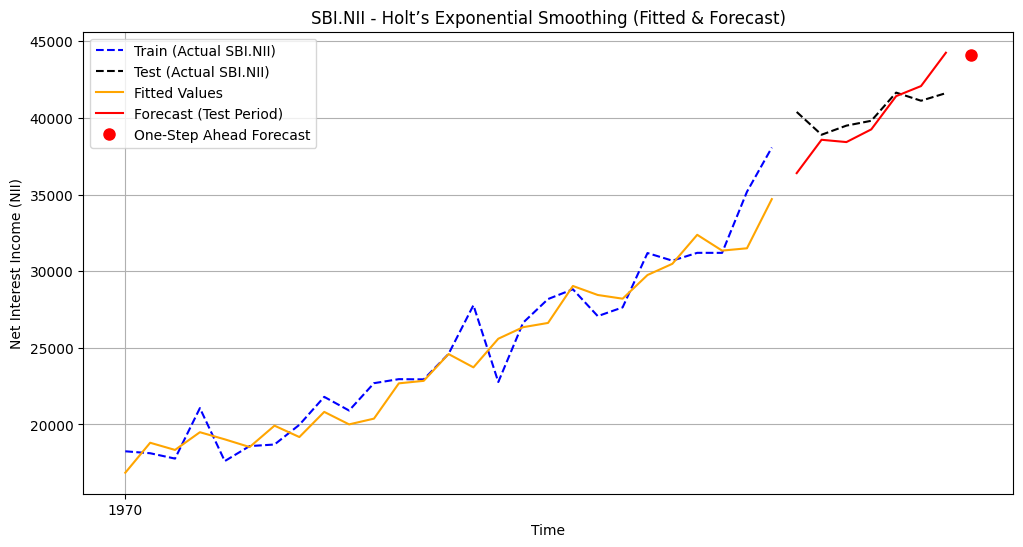

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Load your SBI.NII dataset (Ensure it's a Pandas Series)
# Example: df = pd.read_csv("sbi_nii.csv", parse_dates=["Date"], index_col="Date")
# Assuming 'SBI.NII' is the column name
train_size = int(len(sbi) * 0.8)
train, test = sbi["NII"][:train_size], sbi["NII"][train_size:]

# 2️⃣ Holt’s Exponential Smoothing Model
model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=5)
result = model.fit()

# 3️⃣ Fitted Values & Forecast
fitted_values = result.fittedvalues
forecast_horizon = len(test)
forecast = result.forecast(steps=forecast_horizon)

# 4️⃣ Calculate AIC, BIC, and MAPE
aic = result.aic
bic = result.bic
mape = mean_absolute_percentage_error(test, forecast)

# 5️⃣ Print Metrics
print(f"AIC  : {aic:.2f}")
print(f"BIC  : {bic:.2f}")
print(f"MAPE : {mape}")

# Forecast test period + one step ahead
forecast_horizon = len(test) + 1
forecast = result.forecast(steps=forecast_horizon)

# Plot Actual, Fitted & Forecasted Values
plt.figure(figsize=(12, 6))

plt.plot(train.index, train, label="Train (Actual SBI.NII)", color="blue", linestyle="--")
plt.plot(test.index, test, label="Test (Actual SBI.NII)", color="black", linestyle="--")
plt.plot(train.index, fitted_values, label="Fitted Values", color="orange")
plt.plot(forecast.index[:-1], forecast[:-1], label="Forecast (Test Period)", color="red")
plt.plot(forecast.index[-1:], forecast[-1:], "ro", label="One-Step Ahead Forecast", markersize=8)

plt.title("SBI.NII - Holt’s Exponential Smoothing (Fitted & Forecast)")
plt.xlabel("Time")
plt.ylabel("Net Interest Income (NII)")
plt.legend()
plt.grid()
plt.show()


### REST ni ebar